In [45]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from pydantic import BaseModel, Field
import operator # reducer function needed to merge the results

load_dotenv()

True

In [46]:
model = ChatOpenAI(model='gpt-4o-mini') # for structured output compatatbility

In [47]:
class Evaluation(BaseModel):
    feedback: str = Field(description="Detailed feedback on the Essay")
    score: int = Field(description='Score on Essay out of 10', ge=0, le=10)

In [48]:
structured_model = model.with_structured_output(Evaluation)

In [49]:
essay = """
Donald Trump vs. Elon Musk : A Hypothetical Election Showdown

In the realm of politics and business, few figures capture public imagination quite like Donald Trump and Elon Musk. Both men have dominated headlines for years, albeit in very different ways—Trump as a real-estate mogul turned President of the United States, and Musk as an innovator who has revolutionised industries with Tesla, SpaceX, and other ventures. If these two personalities were to face each other in a political election, the contest would be unlike any the modern world has witnessed.

Trump’s Political Persona
Donald Trump is no stranger to elections. He brings to the table his identity as a former U.S. president, his base of loyal supporters, and his well-honed ability to channel populist rhetoric. Trump has positioned himself as a champion of the “forgotten American,” leveraging nationalism, cultural conservatism, and a combative style to mobilise millions. His experience in rallies, political debates, and policy messaging provides him with a ready-made political machine.

Musk’s Technological Vision
Elon Musk, by contrast, would represent the archetype of the visionary outsider. With his reputation as a technological pioneer, Musk appeals to those who see innovation and science as the future of society. His popularity on social media and ability to influence markets through a single tweet underscore his charisma among tech-savvy younger demographics. Unlike Trump, Musk is not aligned with traditional political ideologies; instead, he projects a futuristic narrative centred on space exploration, renewable energy, and artificial intelligence.

Comparing Their Appeal
The election would come down to which vision resonates more: Trump’s populism rooted in tradition and national pride, or Musk’s disruptive, forward-looking approach. Trump’s advantage lies in his established political brand and experience mobilising voters. Musk’s strength lies in his ability to attract independents, younger voters, and those disillusioned with conventional politics.

However, Musk’s lack of political experience could be a significant hurdle. Navigating governance, diplomacy, and the complexities of policy-making requires skills Musk has yet to demonstrate. On the other hand, Trump’s divisiveness may alienate moderate voters who might find Musk’s outsider status refreshing.

Conclusion
A Trump-Musk election would not simply be a battle of policies but of narratives: one grounded in nostalgia and national identity, the other in innovation and the promise of a technological future. Both candidates would carry unique advantages and disadvantages, making the outcome uncertain. What is clear, however, is that such a contest would redefine the way the world thinks about leadership, politics, and the intersection of power, personality, and progress.
"""

In [50]:
class UPSCstate(TypedDict):
    essay: str
    language_feedback: str
    analysis_feedback: str
    clarity_feedback: str
    overall_feedback: str
    individual_scores: Annotated[list[int], operator.add] # the 3 different feedback scores are coming in a separate list, but we are going to combine all 3 values in one list. so, I have used the reducer function.
    average_score: float

In [51]:
def language_evaluation(state: UPSCstate) -> UPSCstate:
    prompt = f'Evaluate the language quality of the following Essay and provide feedback and a score out of 10:\n{state["essay"]}'
    output = structured_model.invoke(prompt)

    return {'language_feedback': output.feedback, 'individual_scores': [output.score]} # type: ignore

In [52]:
def analysis_evaluation(state: UPSCstate) -> UPSCstate:
    prompt = f'Evaluate the depth of analysis of the following Essay and provide feedback and a score out of 10:\n{state["essay"]}'
    output = structured_model.invoke(prompt)

    return {'analysis_feedback': output.feedback, 'individual_scores': [output.score]} # type: ignore

In [53]:
def clarity_evaluation(state: UPSCstate) -> UPSCstate:
    prompt = f'Evaluate the clarity of thought in the following Essay and provide feedback and a score out of 10:\n{state["essay"]}'
    output = structured_model.invoke(prompt)

    return {'clarity_feedback': output.feedback, 'individual_scores': [output.score]} # type: ignore

In [54]:
def final_evaluation(state: UPSCstate) -> UPSCstate:
    prompt = f'Based on the following feedback, create a summerised feedback - \n {state["analysis_feedback"]}, {state["clarity_feedback"]}, {state["language_feedback"]}'
    overall_feedback = model.invoke(prompt).content

    # average calculation
    average_score = sum(state['individual_scores']) / len(state['individual_scores'])
    return {'overall_feedback': overall_feedback, 'average_score': average_score} # type: ignore

In [55]:
# create graph
graph = StateGraph(UPSCstate)

# add nodes
graph.add_node('language_evaluation',language_evaluation)
graph.add_node('analysis_evaluation',analysis_evaluation)
graph.add_node('clarity_evaluation',clarity_evaluation)
graph.add_node('final_evaluation',final_evaluation)

# add edges
graph.add_edge(START, 'language_evaluation')
graph.add_edge(START, 'analysis_evaluation')
graph.add_edge(START, 'clarity_evaluation')
graph.add_edge('language_evaluation', 'final_evaluation')
graph.add_edge('analysis_evaluation', 'final_evaluation')
graph.add_edge('clarity_evaluation', 'final_evaluation')
graph.add_edge('final_evaluation', END)

# compile graph
workflow = graph.compile()

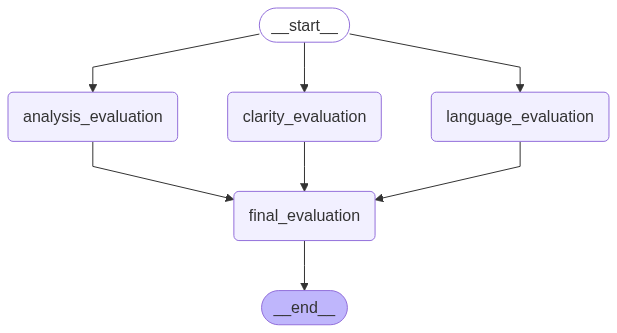

In [56]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

In [58]:
# initial state
initial_state = {'essay': essay}

# final state
final_state = workflow.invoke(initial_state) # type: ignore

In [59]:
final_state

{'essay': '\nDonald Trump vs. Elon Musk : A Hypothetical Election Showdown\n\nIn the realm of politics and business, few figures capture public imagination quite like Donald Trump and Elon Musk. Both men have dominated headlines for years, albeit in very different ways—Trump as a real-estate mogul turned President of the United States, and Musk as an innovator who has revolutionised industries with Tesla, SpaceX, and other ventures. If these two personalities were to face each other in a political election, the contest would be unlike any the modern world has witnessed.\n\nTrump’s Political Persona\nDonald Trump is no stranger to elections. He brings to the table his identity as a former U.S. president, his base of loyal supporters, and his well-honed ability to channel populist rhetoric. Trump has positioned himself as a champion of the “forgotten American,” leveraging nationalism, cultural conservatism, and a combative style to mobilise millions. His experience in rallies, political 